## This notebook is to visualize scattering from D$_3$LiIr$_2$O$_6$. 

Absorption corrections are performed either here or on the analysis cluster.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib
from mantid.simpleapi import *

sys.path.append("../python scripts/")

from nxspetomd import *
from genslices import *
from annularabsorbcorr import *
import MDUtils as mdu
from getcolor import *
import lmfit
from lmfit import Model
from cut_mdhisto_powder import * 
#Style sheet updates 
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'
%matplotlib inline

FrameworkManager-[Notice] Welcome to Mantid 6.9.1
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.9.1
CheckMantidVersion-[Notice] A new version of Mantid(6.11.0) is available for download from https://download.mantidproject.org
DownloadInstrument-[Notice] All instrument definitions up to date


In [3]:
#Vanadium normalization factors, per Ir
# for Ei=30meV FC2=300Hz
van_factor_30 =  45602.6555# mbarn/meV/sr/ mol (Li2IrO3)

fu_hlio_over_lio = 0.0074 / 0.015 # from 3.6g hlio to 3.8g beta-lio
van30_permolfu_hlio = van_factor_30*fu_hlio_over_lio
van_factor_30 = van30_permolfu_hlio / 2.0 # per Ir 
# For Ei=60meV FC2=420Hz 
van_factor_60 = 32195.135
van_factor_60 = van_factor_60*fu_hlio_over_lio / 2.0 

print(f"Normalization for Ei=30 meV : {van_factor_30:.2e}")
print(f"Normalization for Ei=60 meV : {van_factor_60:.2e}")
ei30_100K = 'data/ei30_100K_manualmask.nxspe'
ei30_4K = 'data/ei30_4K_manualmask.nxspe'
ei30_200K = 'data/ei30_200K_manualmask.nxspe'
ei60_4K = 'data/ei60_4K_manualmask.nxspe'
ei60_100K = 'data/ei60_100K_manualmask.nxspe'
ei60_200K = 'data/ei60_200K_manualmask.nxspe'

keys = ['30_4K','30_100K','30_200K','60_4K','60_100K','60_200K']
Q60 = GenQslice(0,5,80)
E60 = GenEslice(-60,60,200)
Q30 = GenQslice(0,4,80)
E30= GenEslice(-30,30,90)
f_dict = {keys[0]:ei30_4K,keys[1]:ei30_100K,keys[2]:ei30_200K,keys[3]:ei60_4K,keys[4]:ei60_100K,keys[5]:ei60_200K}
Ei_dict = {keys[0]:30.0,keys[1]:30.0,keys[2]:30.0,keys[3]:60.0,keys[4]:60.0,keys[5]:60.0}

for key in keys:
    if Ei_dict[key]==30.0:
        Qbin,Ebin = Q30,E30
        van = van_factor_30
    else:
        Qbin,Ebin = Q60,E60
        van = van_factor_60
    # First call is without absorption corrections.
    #ws = NxspeToMDHisto(f_dict[key],Qbins=Qbin,Ebins=Ebin,numEvNorm=False,van_factor=van)
    #ws_norm = NxspeToMD(f_dict[key],van_factor=van)

    # This call is with absorption corrections.
    ws = annularabsorbcorr(f_dict[key], Q_slice=Qbin, E_slice=Ebin,
                           mat_string="(H2)3-(Li7)-(Ir193)2-O6", Ei=Ei_dict[key],
                           outer_r=1.0, inner_r=0.95, samp_thick=0.05, samp_h=4.0,
                       num_density=2.0/225.5, eventnorm=False, wsname="SEQ_"+key)
    ws*=van
    CloneWorkspace(ws,OutputWorkspace=key)
    # ws_norm is exactly the same without a BinMD call at the end.
    ws_norm = annularabsorbcorrMD(f_dict[key], mat_string="(H2)3-(Li7)-(Ir193)2-O6", Ei=Ei_dict[key],
                           outer_r=1.0, inner_r=0.95, samp_thick=0.05, samp_h=4.0,
                       num_density=2.0/225.5, wsname="SEQ_norm_"+key)
    ws_norm = ws_norm*van
    #Be wary that if intensities are normalized to events here mantid will not project properly in matplotlib
    CloneWorkspace(ws_norm,OutputWorkspace=key+'_event')

Normalization for Ei=30 meV : 1.12e+04
Normalization for Ei=60 meV : 7.94e+03
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 0.08 seconds
MergeRuns-[Notice] MergeRuns started
MergeRuns-[Warning] Only one input workspace specified
MergeRuns-[Notice] Using run 'SEQ_30_4K_absorbcorr' as a reference to determine possible rebinning.
MergeRuns-[Notice] MergeRuns successful, Duration 0.01 seconds
ConvertUnits-[Notice] ConvertUnits started
ConvertUnits-[Notice] ConvertUnits successful, Duration 0.02 seconds
AnnularRingAbsorption-[Notice] AnnularRingAbsorption started
AnnularRingAbsorption-[Notice] AnnularRingAbsorption successful, Duration 0.19 seconds
Divide-[Notice] Divide started
Divide-[Notice] Divide successful, Duration 0.00 seconds
ConvertUnits-[Notice] ConvertUnits started
ConvertUnits-[Notice] ConvertUnits successful, Duration 0.02 seconds
ConvertToMD-[Notice] ConvertToMD started
ConvertToMD-[Notice] ConvertToMD successful, Duration 0.03 seconds
BinMD-[Notice] BinM

CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace started
CloneWorkspace-[Notice] CloneWorkspace successful, Duration 0.00 seconds
CloneWorkspace-[Notice] CloneWorkspace s

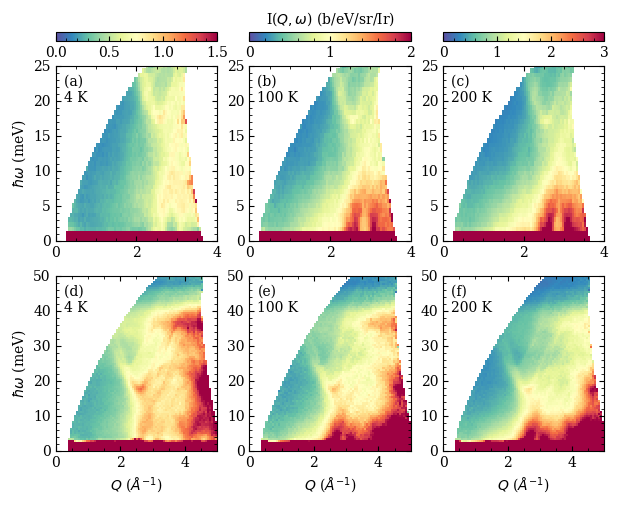

In [4]:
#Begin the figure here. 
from mask_minQ import mask_minQ_fixedEi_MD
fig,ax = plt.subplots(2,3,figsize=(3.54*2,5),subplot_kw={'projection':'mantid'})
axi_dict = {keys[0]:[0,0],keys[1]:[0,1],keys[2]:[0,2],keys[3]:[1,0],keys[4]:[1,1],keys[5]:[1,2]}
label_dict = {keys[0]:'(a) \n4 K',keys[1]:'(b) \n100 K',keys[2]:'(c) \n200 K',keys[3]:'(d) \n4 K',\
              keys[4]:'(e)\n100 K',keys[5]:'(f) \n200 K'}
for key in keys:
    ws = mtd[key]
    Ei = Ei_dict[key]

    ws = mask_minQ_fixedEi_MD(ws,twoThetaMin=4,Ei=Ei)
    ws=ws.clone()
    ax_plot = ax[axi_dict[key][0],axi_dict[key][1]]
    if '4K' in key:
        vmax = 1.5
    elif '100K' in key:
        vmax = 2.0
    elif '200K' in key:
        vmax = 3.0
    mesh = ax_plot.pcolormesh(ws,vmin=0,vmax=vmax,cmap='Spectral_r',rasterized=True)
    if Ei==30:
        ax_plot.set_ylim(0,25)
        ax_plot.set_ylabel('')
        l,b,w,h=ax_plot.get_position().bounds
        cax = fig.add_axes([l,b+h+0.05,w,h/20.0])
        ax_plot.set_xlabel('')

        if axi_dict[key]==[0,1]:
            labelstr='I($Q,\omega$) (b/eV/sr/Ir)'
            cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',\
                    verticalalignment='bottom',rotation=0.0)
        else:
            labelstr=''       
        cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax)
        cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

    else:
        ax_plot.set_ylim(0,50)
        ax_plot.set_ylabel('')
        ax_plot.set_xlabel('$Q$ ($\AA^{-1}$)')
    ax_plot.text(0.05,0.95,label_dict[key],transform=ax_plot.transAxes,verticalalignment='top',horizontalalignment='left')
ax[0,0].set_ylabel('$\hbar\omega$ (meV)')
ax[1,0].set_ylabel('$\hbar\omega$ (meV)')

#ax[0,0].set_title('E$_i$=30 meV')
#ax[1,0].set_title('E$_i$=60 meV')

fig.savefig('dlio_seq_dat.png',dpi=300,bbox_inches='tight')
fig.savefig('dlio_seq_dat.pdf',dpi=300,bbox_inches='tight')

Befactor=1.0000
Expected scaling for 4 K = 1.00, found 1.00
Befactor=0.3337
T=100.0 K BkgC = 0.45027471384761986
Expected scaling for 100 K = 0.33, found 1.00


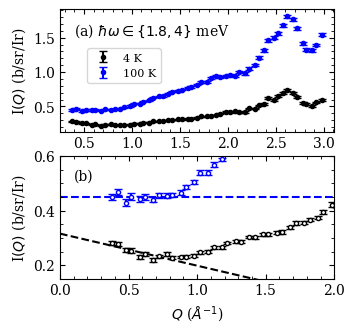

In [83]:
#Also make a figure showing a cut of the energy dependent itensity as a function of temperature for more convincing direct evidence of low energy q-dependence to the scattering.
fig,axs = plt.subplots(2,1,figsize=(3.54,3.5))
from scipy.interpolate import CubicSpline
from scipy.interpolate import splrep, BSpline
from scipy import interpolate
def bkg_model(x,A,C,m):
    return m*x + A*(x**2)+C

colors=['k','b','r']
temps = [4.0,100.0,200.0]
sub_C = [0.0,0.0,0.4]
sub_A = [0.0,0.0,0.0]
labels=['4K','100K','200K']
#Overall scaling factor should follow Bose-Einstein population ratios.
def befactor(t,omega):
    return (1.0-np.exp(-omega/(8.62e-2 * t)))
for i in [0,1]:
    c = colors[i]
    
    q,I,err = cut_MDHisto_powder(mtd[keys[i]],'|Q|',[0.35,3,0.02],[1.8,4.0])
    e,Ie,erre = cut_MDHisto_powder(mtd[keys[i]],'DeltaE',[2,15,0.2],[0.5,1.0])
    befact = befactor(temps[i],np.mean([2.0,5.0]))
    print(f"Befactor={befact:.4f}")
    model = Model(bkg_model)
    params=model.make_params()
    params.add('A',value=sub_A[i],vary=False,min=0.0,max=100.0)
    params.add('C',value=0.6,min=0,max=10)
    params.add('m',value=0.0,min=-10,max=10)

    weight = 1.0/err
    weight[q>0.8]=0
    weight[q<0]=0
    result=  model.fit(I,x=q,weights=weight,method='powell',params=params)

    if i==0:
        highQ_i = np.argwhere(q>2.5)
        meanI_4K = np.trapz(x=q[highQ_i].flatten(),y=I[highQ_i].flatten())
        highQ_int = 1.0
        scale = 1.0
        #scale=befact
        I=I
        I=I#-np.nanmin(I[np.logical_and(q<1.2,q>0.8)])
        label = f"{temps[i]:.0f} K"
        axs[1].errorbar(q,I-sub_C[i],yerr=err,c=c,label=label,marker='o',ls=' ',capsize=3,ms=3,mfc='w')

    else:
        highQ_int = np.trapz(x=q[highQ_i].flatten(),y=I[highQ_i].flatten())
        scale = meanI_4K/highQ_int
        #scale=befact
        print(f"T={temps[i]} K BkgC = {result.params['C'].value}")
        label = f"{temps[i]:.0f} K"
        axs[1].errorbar(q,I-sub_C[i],yerr=err,c=c,label=label,marker='o',ls=' ',capsize=3,ms=3,mfc='w')
    scale=1
    axs[0].errorbar(q,I*scale,yerr=err*scale,c=c,label=label,marker='o',ls=' ',capsize=3,ms=3)
    q_eval = np.linspace(0,3,1000)
    result_eval = model.eval(x=q_eval,params=result.params)
    axs[1].plot(q_eval,result_eval-sub_C[i],color=c,ls='--',zorder=0.1)
    #Print the expected bose-factor as well.
    print(f"Expected scaling for {temps[i]:.0f} K = {befact:.2f}, found {scale:.2f}")
    axs[1].set_xlim(0,2.0)
    axs[1].set_ylim(0.15,0.6)
    #axs[1].set_xlim(0.0,2.0)
    #axs[1].set_ylim(-0.05,np.nanmin(I-sub_C[i])*4)
axs[0].legend(fontsize=8,loc=(0.1,0.4))

axs[1].set_xlabel('$Q$ ($\AA^{-1}$)')
axs[1].set_ylabel('I$(Q)$ (b/sr/Ir)')
axs[0].set_ylabel('I$(Q)$ (b/sr/Ir)')
axs[0].text(0.05,0.9,'(a) '+r"$\hbar\omega\in\{1.8,4\}$ meV",horizontalalignment='left',verticalalignment='top',transform=axs[0].transAxes)
axs[1].text(0.05,0.9,'(b)',horizontalalignment='left',verticalalignment='top',transform=axs[1].transAxes)

fig.savefig('hlio_direct_Qcuts_SEQ.pdf',bbox_inches='tight')

## Now we take advantage of the particular form for multiple scattering used in T. Hong's work. 

The scattering from incoherent scattering then a phonon goes as:

$I'(Q,\omega)=T I(Q,\omega) + (1-T)\int_{|k_i - k_f|}^{k_i+k_f}I'(Q,\omega)\frac{Q'dQ'}{2k_ik_f}$

Assuming thin sample and the phonon scattering goes as $f(\omega)Q^2$

$I'_p(Q,\omega)=f(\omega)(k_i^2 +k_f^2)(T\frac{Q^2}{k_i^2+k_f^2} + (1-T))$

The scattering that would be leftover from this after a bose-einstein high-T subtraction would be (where $B$ is the bose-einstein population factor):

$I_p^{4K} - BI_p^{200K}= (k_i^2 +k_f^2)(T\frac{Q^2}{k_i^2+k_f^2} + (1-T))(f(\omega)^{4K} - B f(\omega)^{200K})$

Knowledge of T and $f(\omega)$ allows for a detailed evaluation of this scattering at high energies. In our case to get the 'magnetic' T=4K scattering we used the T=100K data. Use the highest available Q values to get $f(\omega)$ to try to avoid any possible magnetic scattering

In [12]:
dos_cut = BinMD(mtd['30_200K_event'],AlignedDim0='|Q|,2.7,3.0,1',AlignedDim1='DeltaE,2,25,1')

print(dos_cut.getSignalArray().flatten())

BinMD-[Notice] BinMD started
[8122.10717276]
BinMD-[Notice] BinMD successful, Duration 0.00 seconds


BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
BinMD-[Notice] BinMD started
BinMD-[Notice] BinMD successful, Duration 0.00 seconds
Fraction of Single_event scattering = 0.9028219414475436


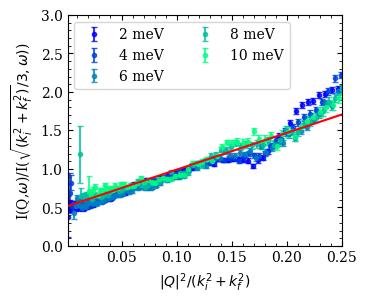

In [13]:
fig,ax = plt.subplots(1,1,figsize=(3.54,3))
slope_arr=[]
b_arr=[]
def lin_model(x,m,b):
    return m*x+b


maxE=10.0
minE=2.
numE=5
for E in np.linspace(minE,maxE,numE):
    estr=f"DeltaE,{E-0.5},{E+0.5},1"

    #For a number of energies, take constant E cuts that should collapse onto eachother.
    dos_cut = BinMD(mtd['30_200K_event'],AlignedDim0='|Q|,0,4.5,150',AlignedDim1=estr)
    dims = dos_cut.getNonIntegratedDimensions()
    q = mdu.dim2array(dims[0])
    cut = np.copy(dos_cut.getSignalArray())/np.copy(dos_cut.getNumEventsArray())
    err = np.sqrt(np.copy(dos_cut.getErrorSquaredArray()))/np.copy(dos_cut.getNumEventsArray())
    lambda_i = np.sqrt(81.82 / (30.0))
    lambda_f =np.sqrt(81.81 / (30.0-E))
    ki = 2.0*np.pi/lambda_i
    kf = 2.0*np.pi/lambda_f
    q_val = np.sqrt(ki**2 +kf**2)/3.0
    kisqr_kfsqr = (ki**2 + kf**2)
    qstr=f"|Q|,{q_val-0.04:.3f},{q_val+0.04:.3f},1"
    estr=f"DeltaE,{E-0.5},{E+0.5},1"
    point = BinMD(mtd['30_200K_event'],AlignedDim0=qstr,\
                                           AlignedDim1=estr)
    ipoint = np.copy(point.getSignalArray()).flatten()/np.copy(point.getNumEventsArray().flatten())
    errpoint = np.sqrt(np.copy(point.getErrorSquaredArray()).flatten())\
        /np.copy(point.getNumEventsArray().flatten())

    y_arr = cut/np.mean(ipoint)
    yerr = np.sqrt(err**2 + np.mean(errpoint)**2)/np.mean(ipoint)
    x = q**2 / (kisqr_kfsqr)
    c = get_color_from_value(E,minE,maxE,'winter')
    ax.errorbar(x,y_arr.flatten(),yerr=yerr.flatten(),marker='o',\
                ls=' ',capsize=2,label=str(int(E))+' meV',alpha=0.8,color=c,ms=3)
    lin_mod = Model(lin_model)
    lin_params = lin_mod.make_params()
    lin_params.add('m',value=1.0,min=0,max=10)
    lin_params.add('b',value=0.4,min=0.1,max=3.0)
    weights=1.0/np.array(yerr)
    weights[np.where(x<0.04)]=0
    lin_result = lin_mod.fit(y_arr.flatten(),x=x,params=lin_params,nan_policy='omit')
    slope_arr.append(lin_result.params['m'].value)
    b_arr.append(lin_result.params['b'].value)

linplot_x = np.linspace(0,0.25,1000)
lin_eval_y = lin_model(linplot_x,np.mean(slope_arr),np.mean(b_arr))
T_val = 9.0*(np.mean(b_arr)-1.0)/(8.0*np.mean(b_arr)-9.0)
T_val2 = 9.0*np.mean(slope_arr) / (8.0*np.mean(slope_arr) +9.0)
Tval_30 = np.mean([T_val,T_val2])
Tval_60 = 0.92
print(f"Fraction of Single_event scattering = {Tval_30}")
ax.plot(linplot_x,lin_eval_y,'r-',zorder=100)
ax.legend(loc=2,ncol=2)
#plt.ylim(0,2.8)
#plt.xlim(0,0.3)
ax.set_xlabel('$|Q|^2 /(k_i^2+k_f^2)$')
ax.set_ylabel('I(Q,$\omega$)/I($\sqrt{(k_i^2 + k_f^2)}/3,\omega)$)')
ax.set_title('')
#plt.text(0.1,0.8,'T='+str(round(Tval_30,3)),fontsize=14,transform=ax.transAxes)
ax.set_xlim(0.001,np.max(linplot_x))
ax.set_ylim(0,3.0)

fig.savefig('HLIO_T_extract.png',bbox_inches='tight')
fig.savefig('HLIO_T_extract.pdf',bbox_inches='tight')
#Now that T has been extracted, get the respective DOS and do the subtraction
#The function below handles all of that! returns a workspace with the mutl-scatt contribution subtracted
# from the low-T workspace

IntegrateMDHistoWorkspace-[Notice] IntegrateMDHistoWorkspace started
IntegrateMDHistoWorkspace-[Notice] IntegrateMDHistoWorkspace successful, Duration 0.01 seconds
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace started
CreateSingleValuedWorkspace-[Notice] CreateSingleValuedWorkspace successful, Duration 0.00 seconds
DivideMD-[Notice] DivideMD started
DivideMD-[Notice] DivideMD successful, Duration 0.00 seconds
SaveMD-[Notice] SaveMD started
Instrument-[Warning] Saving Instrument with no XML data. If this was instrument data you may not be able to load this data back into Mantid, for fitted/analysed data this warning can be ignored.
SaveMD-[Notice] SaveMD successful, Duration 0.03 seconds


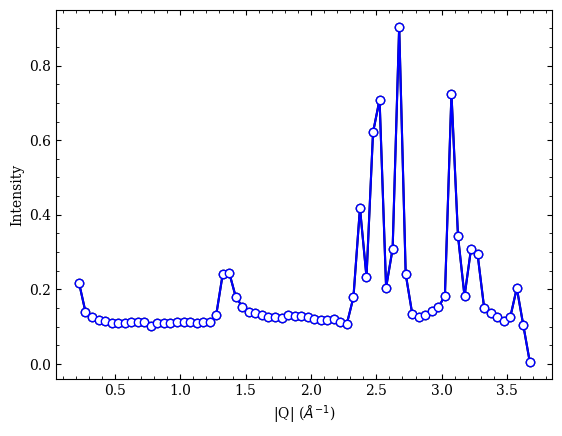

In [14]:
# To normalize the other measurements, we must integrate the elastic line.
# This integration can be matched to the HYS, MACS measurements. 

Integrated30 = IntegrateMDHistoWorkspace(mtd[keys[0]],P1Bin=[],P2bin=[-2,2])
Integrated30/=1e3 # Integration should be in eV not meV

dims = Integrated30.getNonIntegratedDimensions()
q = mdu.dim2array(dims[0])
I = np.copy(Integrated30.getSignalArray()).flatten()
Err = np.sqrt(np.copy(Integrated30.getErrorSquaredArray())).flatten()
numEv = np.copy(Integrated30.getNumEventsArray())[:,0]

I/=numEv
Err/=numEv
good_i = I>0 & ~np.isnan(I)


fig,ax = plt.subplots(1,1,subplot_kw={'projection':'mantid'})
ax.errorbar(Integrated30,color='k',marker='o',mfc='w',mec='k',ls='-')
ax.errorbar(q[good_i],I[good_i],Err[good_i],color='b',marker='o',mfc='w',mec='b',ls='-')

#Save this for later normalization 
SaveMD(Integrated30,'../MDHisto_files/seq30_int_elline.nxs')